<a href="https://colab.research.google.com/github/ayush29feb/nn-experiments/blob/master/gan/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks: MNIST

A simple GAN for generating handwritten digits drawings similar to MNIST Dataset

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
if use_cuda:
  print('Using GPU: %s'% torch.cuda.get_device_name(0))

Using GPU: Tesla K80


# Parameters

In [0]:
batch_size=10
img_dim=784

d_lr=0.0002
g_lr=0.0002
num_epochs=100
dropout_rate=0.3

z_dim=100
g_steps=1
d_steps=1

## Load The MNIST Dataset

In [0]:
# !mkdir /content/data
data_root='/content/data'
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Lambda(lambda x: (x-0.5)/0.5)])

train_set = datasets.MNIST(root=data_root, train=True, 
                           transform=data_transforms, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

## Generator

In [0]:
class Generator(nn.Module):
  
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, img_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.tanh(x)
        return x.view(-1, 1, 28, 28)

## Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(img_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, 0.3)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# Training


In [0]:
def extract(v):
    return v.data.storage().tolist()

In [17]:
G = Generator()
D = Discriminator()
if use_cuda:
  G = G.cuda()
  D = D.cuda()
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_lr)
g_optimizer = optim.Adam(G.parameters(), lr=g_lr)

for epoch in range(num_epochs):
  for i, (x, _) in enumerate(train_loader):
  
    if use_cuda:
      x = x.cuda()

    # 1. Train D on real+fake
    D.zero_grad()

    #  1A: Train D on real
    d_real_data = Variable(x)
    d_real_decision = D(d_real_data)
    d_real_labels = torch.ones(batch_size) # ones = true
    if use_cuda:
      d_real_labels = d_real_labels.cuda()
    d_real_error = criterion(d_real_decision, Variable(d_real_labels))  
    d_real_error.backward() # compute/store gradients, but don't change params

    #  1B: Train D on fake
    d_z = torch.randn(batch_size, z_dim)
    if use_cuda:
      d_z = d_z.cuda()
    d_gen_input = Variable(d_z)
    d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
    d_fake_decision = D(d_fake_data)
    d_fake_labels = torch.zeros(batch_size) # zeros = fake
    if use_cuda:
      d_fake_labels = d_fake_labels.cuda()
    d_fake_error = criterion(d_fake_decision, Variable(d_fake_labels)) 
    d_fake_error.backward()
    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    # 2. Train G on D's response (but DO NOT train D on these labels)
    G.zero_grad()

    g_z = torch.randn(batch_size, z_dim)
    if use_cuda:
      g_z = g_z.cuda()
    gen_input = Variable(g_z)
    g_fake_data = G(gen_input)
    dg_fake_decision = D(g_fake_data)
    dg_fake_labels = torch.ones(batch_size)
    if use_cuda:
      dg_fake_labels = dg_fake_labels.cuda()
    g_error = criterion(dg_fake_decision, Variable(dg_fake_labels))  # we want to fool, so pretend it's all genuine

    g_error.backward()
    g_optimizer.step()  # Only optimizes G's parameters

  if epoch % 1 == 0:
      print("%s: D: %s/%s G: %s" % (epoch,
                                    extract(d_real_error)[0],
                                    extract(d_fake_error)[0],
                                    extract(g_error)[0]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.008815480396151543/0.019994014874100685 G: 5.408061981201172
1: D: 0.0064512281678617/0.04888596385717392 G: 2.3822500705718994
2: D: 0.0018764892593026161/0.514936625957489 G: 2.416656494140625
3: D: 0.5222370028495789/0.3136095404624939 G: 2.527367115020752
4: D: 0.6542896032333374/0.4390343725681305 G: 1.9788920879364014
5: D: 0.14024768769741058/0.3854864239692688 G: 1.1669175624847412
6: D: 0.8473265767097473/0.32413625717163086 G: 1.9464260339736938
7: D: 0.537171483039856/0.28617867827415466 G: 1.3709501028060913
8: D: 0.66823810338974/0.49794521927833557 G: 1.4135640859603882
9: D: 0.669575572013855/0.4740068316459656 G: 1.4080054759979248
10: D: 0.4708629250526428/0.3165932893753052 G: 1.2402751445770264


KeyboardInterrupt: ignored

In [0]:
d_z = torch.randn(batch_size, z_dim)
if use_cuda:
  d_z = d_z.cuda()
results = G(Variable(d_z)).detach()

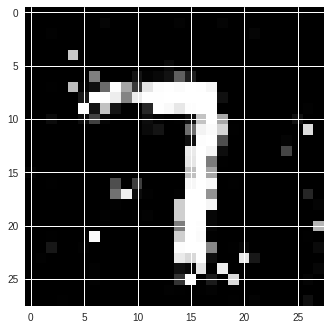

In [35]:
res = results.cpu().numpy()
plt.imshow(1 - (res[7][0] / 2 + 0.5))